# Overview

Our goal is to make a noise map with:
- Spatially anisotropic noise
- Spatially correlated
- With a reasonable mean

Method:
1. Get a target statistics (power spectrum, mean, variance)
2. Get an anisotropic white noise map (white = flat spatial correlation)
3. Filter the white noise map, giving spatial correlation
4. Adjust the filtered map

I skip handling units properly in this notebook. The final results will have incorrect units if using 545 or 857 GHz maps. The upside is that this is far simpler.

### Boilerplate and Visualization

In [1]:
from pathlib import Path
from itertools import product
import logging

import numpy as np
import healpy as hp
from sklearn.decomposition import PCA
from astropy.io import fits

import matplotlib.pyplot as plt
import matplotlib.transforms as transforms

from tqdm.notebook import tqdm  # For progress bars

from cmbml.utils.handle_data import get_map_dtype, get_planck_obs_data, get_planck_noise_data

In [2]:
logger = logging.getLogger("handle_data")
logger.setLevel(logging.DEBUG)

In [22]:
def plot_many_ps(ps_s,
            title=None, 
            x_low=0.7,
            x_high=1e4,
            y_low=1e-4,
            y_high=1e-2,
            styles=None,
            labels=None,
            white_noise_expected=None,
            legend=True,
            focus_first=False):
    y_label="$N_{\\ell}$" + "($K_{CMB}^2$)"
    x_label="$\\ell$"
    plt.figure()
    for i, ps in enumerate(ps_s):
        ells = np.arange(len(ps)).astype(float)
        if x_low < 1:
            ells[0] = x_low
        style=None
        linewidth=None
        color=None
        if styles is None:
            pass
        elif styles[i] != "-":
            style = styles[i]
            linewidth = 2
        else:
            style = styles[i]
            linewidth = 1
        if focus_first and i == 0:
            color='black'
            linewidth=3
        label = None if labels is None else labels[i]
        plt.plot(ells, ps, label=label, linestyle=style, color=color, linewidth=linewidth)
    # if white_noise_expected is not None:
    #     plt.axhline(y=white_noise_expected, color='black', linestyle='--', linewidth=1)
    #     plt.text(y=white_noise_expected, x=x_high, s="$\\sigma_{\\ell}=" + f"{white_noise_expected:.1e}$", 
    #              color='black',
    #              horizontalalignment='right', verticalalignment='bottom')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim([x_low-0.00001, x_high])
    plt.ylim([y_low, y_high])
    plt.title(title)
    if legend:
        plt.legend()
    plt.show()

# Parameters

In [3]:
DATA_ROOT = "/data/jim/CMB_Data/"
ASSETS_DIRECTORY = f"{DATA_ROOT}/Assets/Planck/"
PLANCK_NOISE_DIR = f"{DATA_ROOT}/Planck_Noise/"
SEED = 42
np.random.seed(SEED)

DETECTOR = 100
N_PLANCK_SIMS = 10

In [4]:
def get_lmax_for_nside(nside):
    return 3 * nside - 1
NSIDE_SRC = 2048
LMAX_SRC = get_lmax_for_nside(NSIDE_SRC)

NSIDE_OUT = 512
LMAX_OUT = get_lmax_for_nside(NSIDE_OUT)

# 1. Get Target statistics

1. Getting Target statistics
    1. Get mean and $C_\ell$ for each map in the source distribution (are these $C_\ell$ or $N_\ell$?)
    2. Get average and standard deviation of means, $\mu_s$, $\sigma_s$
    3. Get variance summary for the $C_\ell^{(s)}$'s using PCA
    4. Draw a target mean from $\sim \mathcal{N}(\mu_s, \sigma_s)$
    5. Draw a target $C_\ell^{(t)}$

In [5]:
# 1.1 For each source map (planck noise simulation), get the mean intensity value and power spectrum
# This is the longest step in the process; taking ~30s per simulation
src_means = []
src_cls = []
for i in range(N_PLANCK_SIMS):
    src_map_fn = get_planck_noise_data(detector=DETECTOR, 
                                       assets_directory=PLANCK_NOISE_DIR, 
                                       realization=i)
    src_map = hp.read_map(src_map_fn)
    src_means.append(np.mean(src_map))
    src_cls.append(hp.anafast(src_map, lmax=LMAX_SRC))

# del src_map, src_map_fn  # Clean up namespace

In [6]:
# 1.2 Get average and standard deviation of means
src_mean = np.mean(src_means)
src_std = np.std(src_means)

# del src_means, src_std  # Clean up namespace

In [7]:
# 1.3 Get variance summary
log_src_cls = np.log10(src_cls)
pca = PCA().fit(log_src_cls)
mean_src_cl = pca.mean_
components_src_cl = pca.components_
variance_src_cl = pca.explained_variance_

# del pca, log_src_cls  # Clean up namespace

Normally with PCA, we would keep only a minimal number of components. I think we should just keep all of them at little extra cost.

See [this other notebook](pca_method_evluation.ipynb#number-of-components) for explained variance curves with more samples. I think it makes sense that we don't see a clear knee. We're looking at a TON of terms (6,144) and have only 100 samples at max.

In [8]:
# 1.4 Draw a target mean
tgt_mean = np.random.normal(src_mean, src_std)

In [9]:
# 1.5 Draw a target power spectrum
n_components = len(components_src_cl)
std_dev_cl = np.sqrt(variance_src_cl)
samples_cl = np.random.normal(0, std_dev_cl, (n_components,))

log_tgt_cl = samples_cl @ components_src_cl + mean_src_cl
tgt_cl = 10 ** log_tgt_cl

# del n_components, std_dev_cl, samples_cl, log_tgt_cl  # Clean up namespace

# 2. Get Anisotropic White Noise Map

2. Get Anisotropic White Noise Map
    1. Get a pixel-wise scaling map from the observation variance map (from Planck)
    2. Draw flat white noise, scale it
    3. Reverse monopole if needed

In [10]:
# Helper function needed for the first step.
def _change_variance_map_resolution(m, nside_out):
    """
    Downgrade a map.
    """
    power = 2  # For variance maps

    # From PySM3 template.py's read_map function, with minimal alteration (added 'power'):
    m_dtype = get_map_dtype(m)
    nside_in = hp.get_nside(m)
    if nside_out < nside_in:  # do downgrading in double precision, per healpy instructions
        m = hp.ud_grade(m.astype(np.float64), power=power, nside_out=nside_out)
    elif nside_out > nside_in:
        m = hp.ud_grade(m, power=power, nside_out=nside_out)
    m = m.astype(m_dtype, copy=False)
    # End of used portion

    return m

In [11]:
# 2.1 Get the scaling map
obs_fn = get_planck_obs_data(detector=DETECTOR, assets_directory=ASSETS_DIRECTORY)
II_cov_map = hp.read_map(obs_fn, field=4)  # Field 4 is the II covariance map
II_cov_map_512 = _change_variance_map_resolution(II_cov_map, NSIDE_OUT)
scale_map = np.sqrt(II_cov_map_512)

# del obs_fn, II_cov_map, II_cov_map_512  # Clean up namespace

In [12]:
# 2.2 Draw and scale flat white noise
wht_noise = np.random.normal(size=scale_map.size) * scale_map

wht_noise = wht_noise - np.mean(wht_noise)

# del scale_map  # Clean up namespace

In [13]:
# # 2.3 Flip sign of monopole if needed
# wht_noise_sign = np.sign(np.mean(wht_noise))
# tgt_mean_sign = np.sign(tgt_mean)
# if wht_noise_sign != tgt_mean_sign:
#     wht_noise = -wht_noise

# # del wht_noise_sign, tgt_mean_sign  # Clean up namespace

# 3. Filter White Noise Map

3. Filter white noise map
    1. Get white noise $a_{\ell m}^{(w)}$'s and $C_\ell^{(w)}$'s
    2. Create filter from $C_\ell^{(w)}$'s and $C_\ell^{(t)}$'s
    3. Apply filter to $a_{\ell m}^{(w)}$'s
    4. Convert $a_{\ell m}^{(f)}$ to filtered map

In [14]:
# 3.1 Get white noise alm's and cl's
wht_noise_alm = hp.map2alm(wht_noise, lmax=LMAX_OUT)
wht_noise_cl = hp.alm2cl(wht_noise_alm)

In [21]:
wht_noise_cl[0]

5.091999468584606e-23

In [15]:
# 3.2 Create filter from white noise cl's and target cl's
correlation_filter = np.sqrt(tgt_cl[:LMAX_OUT+1] / wht_noise_cl)

In [16]:
# 3.3 Apply filter to white noise alm'set

# alm's are stored in a non-intuitive order; we let healpy handle the 
#    application of the filter (which is per l) to each a_lm
filtered_alms = hp.almxfl(wht_noise_alm, correlation_filter)
# del wht_noise_alm  # Clean up namespace

In [17]:
# 3.4 Convert filtered alm's to map
filtered_map = hp.alm2map(filtered_alms, nside=NSIDE_OUT)

# 4. Adjust Filtered Map

4. If the mean of the filtered map is outside a reasonable range, change it out for the target mean determined above.

In [18]:
min_dist_tgt = src_mean - 3*src_std
max_dist_tgt = src_mean + 3*src_std
if filtered_map.mean() < min_dist_tgt or filtered_map.mean() > max_dist_tgt:
    filtered_map = filtered_map - filtered_map.mean() + tgt_mean
del min_dist_tgt, max_dist_tgt  # Clean up namespace

I chose to do this based on the distributions I see of the values for $C_\ell$ at different $\ell$ in histograms comparing the Planck source noise and the simulations I output. Those histograms are [in this section of this notebook](pca_method_evluation.ipynb#look-at-regular-scale-cls-not-log-scale).

# Examine Result

Note that the units are $K_{CMB}$ instead of $\mu K_{CMB}$; the scales may seem a bit off.

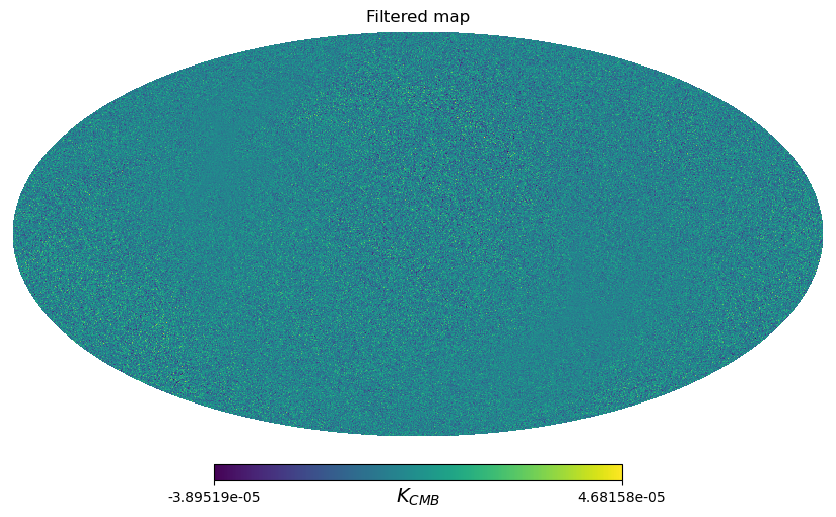

In [19]:
hp.mollview(filtered_map, unit="$K_{CMB}$", title="Filtered map")

In [ ]:
filtered_cl = hp.anafast(filtered_map, lmax=LMAX_OUT)

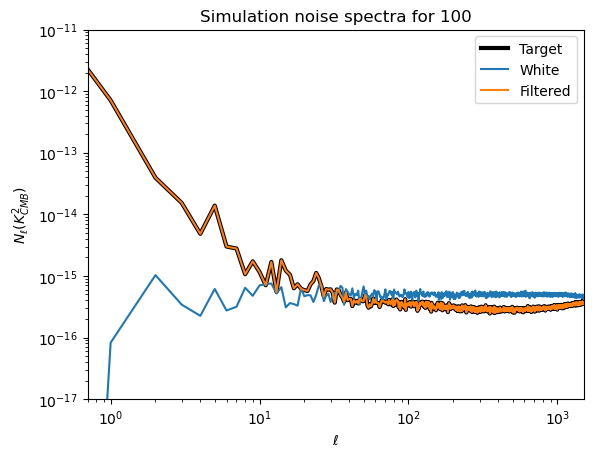

In [24]:
plot_many_ps([
                tgt_cl[:LMAX_OUT+1], 
                wht_noise_cl, 
                filtered_cl],
                labels=[
                    'Target', 
                    'White', 
                    'Filtered'
                    ],
                title=f'Simulation noise spectra for {DETECTOR}',
                y_low=1e-17, y_high=1e-11,
                x_low=0.7, x_high=1500,
                focus_first=True
                )